In [1]:
# Copyright 2011-2019 Kwant authors.
#
# This file is part of Kwant.  It is subject to the license terms in the file
# LICENSE.rst found in the top-level directory of this distribution and at
# http://kwant-project.org/license.  A list of Kwant authors can be found in
# the file AUTHORS.rst at the top-level directory of this distribution and at
# http://kwant-project.org/authors.

from packaging import version

import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.sparse as sp

__all__ = ["find_boundstates"]

# TODO: remove this when we depend on scipy > 1.1
#1.3.1 here
if version.parse(scipy.__version__) > version.parse("1.1"):
    null_space = scipy.linalg.null_space
else:

    def null_space(A, rcond=None):
        u, s, vh = scipy.linalg.svd(A, full_matrices=True)
        M, N = u.shape[0], vh.shape[1]
        if rcond is None:
            rcond = np.finfo(s.dtype).eps * max(M, N)
        tol = np.amax(s) * rcond
        num = np.sum(s > tol, dtype=int)
        Q = vh[num:, :].T.conj()
        return Q


# If available, use MUMPS support for shift-inverse sparse diagonalization
# Can import mumps alright.
try:
    from kwant.linalg import mumps
except ImportError:
    sparse_diag = sp.linalg.eigsh
else:

    class _LuInv(sp.linalg.LinearOperator):
        def __init__(self, A):
            inst = mumps.MUMPSContext()
            inst.analyze(A)
            inst.factor(A)
            self.solve = inst.solve
            super().__init__(A.dtype, A.shape)

        def _matvec(self, x):
            return self.solve(x.astype(self.dtype))

    def sparse_diag(matrix, k, sigma, **kwargs):
        if sigma == 0:
            shifted_matrix = matrix
        else:
            shifted_matrix = matrix - sigma * sp.identity(matrix.shape[0])
        return sp.linalg.eigsh(matrix, k, sigma=sigma, OPinv=_LuInv(shifted_matrix),
                               **kwargs)

"""syst: kwant.system.FiniteSystem
"""

def find_boundstates(
    syst,
    min_energy,
    max_energy,
    params=None,
    sparse=True,
    check_hermiticity=True,
    rtol=1e-3,
):
    """Return boundstates of an open system in an energy window

    Parameters
    ----------
    syst : kwant.system.FiniteSystem
        Must have leads.
    min_energy, max_energy : float
        The lower and upper bounds in energy to search for boundstates.
    params : dict, optional
        The keyword arguments to 'syst'.
    sparse : bool, default: True
        If True use sparse linear algebra, otherwise use dense.
    check_hermiticity : bool, default: True
        If True, checks the Hermiticity of the system Hamiltonian
    rtol : float, default: 1E-3
        boundstates that are closer together than
        'rtol * (max_energy - min_energy)' may be missed.

    Returns
    -------
    energies : 1D float array
        The energies of the bound states.
    wavefunctions : 2D complex array
        The columns are the bound state wavefunctions defined
        over the scattering region.
    """

    # TODO: apply lru_cache to this once
    # https://github.com/scipy/scipy/issues/10846 is solved.
    def min_eigenvalue(energy):
        H_eff = make_linsys(
            syst,
            energy,
            params=params,
            sparse=sparse,
            check_hermiticity=check_hermiticity,
        )
        try:
            if sparse:
                if H_eff.shape[0] <= 2:
                    raise ValueError(
                        "The system is too small to use sparse diagonalization. "
                        "Try setting 'sparse=False'."
                    )
                vals = sparse_diag(
                    H_eff.tocsc(), k=1, sigma=0, which="LM", return_eigenvectors=False
                )
                return vals[0]
            else:
                vals = np.linalg.eigvalsh(H_eff)
                which = np.argmin(np.abs(vals))
                return vals[which]
        except RuntimeError:  # Some problem diagonalizing
            return np.inf

    if syst.site_ranges is not None:
        tot_norbs = syst.site_ranges[-1][-1]
    else:
        _, norbs = syst.hamiltonian_submatrix(params=params, return_norb=True)[:2]
        tot_norbs = sum(norbs)

    # Grid the energy window and search for roots in the sub-windows
    # where the min-eigenvalue changes sign. These will either be
    # true roots or discontinuities. Note that if there are >1 roots
    # in the same sub-window then at least one of them will be missed.
    energies = np.linspace(
        min_energy, max_energy, int((max_energy - min_energy) / rtol)
    )
    intervals = zip(energies, energies[1:])
    candidates = []
    for a, b in intervals:
        if np.sign(min_eigenvalue(a)) != np.sign(min_eigenvalue(b)):
            candidate = scipy.optimize.brentq(min_eigenvalue, a, b)
            candidates.append(candidate)

    # Check which candidate points give actual boundstates.
    energies = []
    states = []
    for energy in candidates:
        vecs = extract_boundstates(syst, energy, params=params, sparse=sparse)
        # vecs.shape[1] == 0 if there were no boundstates found
        energies.append([energy] * vecs.shape[1])
        # Here we discard the mode part of the solution just to
        # make the output format more uniform (wavefunction has
        # same number of components at all energies).
        states.append(vecs[:tot_norbs, :])

    if not energies:
        return np.empty((0,)), np.empty((tot_norbs, 0))
    else:
        return np.hstack(energies), np.hstack(states)


def extract_boundstates(
    syst, energy=0, params=None, sparse=True, check_hermiticity=True, tol=1e-8
):
    """Return any true boundstates of 'syst' at 'energy'

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity

    Returns
    -------
    vecs : 2D array
        The columns are bound state wavefunctions.
        The first N rows is in the tight-binding basis of the
        scattering region, and the remaining rows are in the
        basis of stabilized evanescent modes of the leads.

    Notes
    -----
    We diagonalize the linear system returned by 'make_linsys', and
    search for zero eigenvalues. We then look for vectors in the basis
    of zero-eigenvalue eigenvectors that satisfy the bound state condition,
    eq. 19 of https://doi.org/10.21468/SciPostPhys.4.5.026.
    """

    lhs, T = make_linsys(
        syst,
        energy,
        params=params,
        sparse=sparse,
        check_hermiticity=check_hermiticity,
        return_validation=True,
        which="hermitian",
    )

    if sparse:
        if lhs.shape[0] <= 2:
            raise ValueError(
                "The system is too small to use sparse diagonalization. "
                "Try setting 'sparse=False'."
            )
        k = min(6, lhs.shape[0] - 2)  # 6 is the default for sp.linalg.eigsh
        try_again = True
        # Solve the eigenproblem with successively large values of 'k' until
        # we get all the zero eigenvalues. (In most cases this loop will
        # run once).
        while try_again:
            vals, vecs = sparse_diag(lhs.tocsc(), k=k, sigma=0, which="LM")
            zeros = np.abs(vals) < tol  # TODO: make this check better
            if not np.all(zeros):  # we have found all the zero eigenvalues
                try_again = False
            else:
                k *= 2  # try again with twice the number of eigenvalues
                if k >= lhs.shape[0] - 1:
                    raise ValueError(
                        "More eigenvalues are 0 than can be obtained by "
                        "sparse diagonalization. Try setting 'sparse=False'."
                    )
    else:
        vals, vecs = np.linalg.eigh(lhs)
        zeros = np.abs(vals) < tol  # TODO make this check better

    if not np.any(zeros):
        return np.empty((lhs.shape[0], 0))


    zero_vecs = vecs[:, zeros]
    # To find the true boundstates we find the null space of the operator
    # in eq 19 (T) in the basis of zero-eigenvalue vectors.
    p = T @ zero_vecs
    if np.allclose(p, 0):
        # 'zero_vecs' are already a basis for the null space of T
        return zero_vecs
    else:
        # TODO: not sure about this value for 'rcond', we need to ensure
        #       that rcond is sufficiently large in the case that p is
        #       zero (i.e. zero_vecs are individually boundstates).
        bound_states = null_space(p, rcond=tol / np.max(np.abs(p)))
        # transform back to original basis
        # TODO: rotate the basis so the bound states have the correct symmetries
        return np.asarray(zero_vecs @ bound_states)


def make_linsys(
    syst,
    energy=0,
    params=None,
    sparse=True,
    check_hermiticity=True,
    return_validation=False,
    which="hermitian",
):
    """Return the linear system for finding boundstates

    Returns ether the linear system defined in equation 12 or equation 11
    of https://doi.org/10.21468/SciPostPhys.4.5.026, and the linear
    operator defined in equation 19 of the same article.

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity
    return_validation: bool, default: False
        If True, also return the linear operator used for
        checking for true bound states (equation 19 of the article).
    which : str, default: "hermitian"
        Which linear system to return. If "hermitian" returns the
        linear system defined in equation 12, if "svd" returns
        the linear system defined in equation 11.

    Returns
    -------
    lhs : 2D array or sparse matrix
        The linear system for finding boundstates
    T : 2D array or sparse matrix
        A linear operator for checking bound states.
        zero-eigenvalue eigenvectors of 'lhs' that are in the
        null-space of 'T' are true bound states. Only returned
        if 'return_validation' is True.
    """
    if not syst.leads:
        raise ValueError("'syst' must have leads attached")
    if any(interface.shape[0] == 0 for interface in syst.lead_interfaces):
        raise ValueError(
            "All the leads of 'syst' must have non-zero " "inter-cell hopping"
        )

    lhs, norb = syst.hamiltonian_submatrix(
        params=params, sparse=sparse, return_norb=True
    )[:2]
    offsets = np.empty(norb.shape[0] + 1, int)
    offsets[0] = 0
    offsets[1:] = np.cumsum(norb)
    scattering_region_norbs = offsets[-1]

    if check_hermiticity and len(lhs.data):
        rtol = 1e-13
        atol = 1e-300
        tol = rtol * np.max(np.abs(lhs.data)) + atol
        if np.any(np.abs((lhs - lhs.T.conj()).data) > tol):
            raise ValueError(
                "System Hamiltonian is not Hermitian. "
                "Use option `check_hermiticity=False` "
                "if this is intentional."
            )

    if sparse:
        lhs = lhs - energy * sp.identity(lhs.shape[0])
    else:
        lhs.flat[:: (offsets[-1] + 1)] -= energy

    phi_e = []
    svd_vs = []
    transfs = []
    for leadnum, interface in enumerate(syst.lead_interfaces):
        lead = syst.leads[leadnum]
        _, stab = lead.modes(energy, params=params)
        svd_v = stab.sqrt_hop
        # Evanescent modes (schur vectors) are stored after
        # the 2*nmodes propagating (in/out) modes
        evan_vecs = slice(2 * stab.nmodes, None)
        u_out = stab.vecs[:, evan_vecs]
        ulinv_out = stab.vecslmbdainv[:, evan_vecs]

        # Construct a matrix of 1's that translates the
        # inter-cell hopping to a proper hopping
        # from the system to the lead.
        iface_orbs = np.r_[tuple(slice(offsets[i], offsets[i + 1]) for i in interface)]

        n_lead_orbs = svd_v.shape[0]
        if n_lead_orbs != len(iface_orbs):
            msg = (
                "Lead {0} has hopping with dimensions "
                "incompatible with its interface dimension."
            )
            raise ValueError(msg.format(leadnum))

        coords = np.r_[[np.arange(len(iface_orbs))], [iface_orbs]]
        transf = sp.csc_matrix(
            (np.ones(len(iface_orbs)), coords), shape=(iface_orbs.size, lhs.shape[0])
        )

        phi_e.append(ulinv_out)
        svd_vs.append(svd_v)
        # We are saving these for use in '_validation_operator', where we
        # expect each projector to project *from the scattering region only*,
        # hence the slice up to 'scattering_region_norbs'
        transfs.append(transf[:, :scattering_region_norbs])

        if which == "hermitian":
            A, B, C = _hermitian_matrices(svd_v, transf, u_out, ulinv_out)
        elif which == "svd":
            A, B, C = _svd_matrices(svd_v, transf, u_out, ulinv_out)
        else:
            raise ValueError("'which' must be 'hermitian' or 'svd'")

        if sparse:
            A = sp.csc_matrix(A)
            B = sp.csc_matrix(B)
            C = sp.csc_matrix(C)
            lhs = sp.bmat([[lhs, A], [B, C]])
        else:
            lhs = np.block([[lhs, A], [B, C]])

    if return_validation:
        return (
            lhs,
            _validation_operator(
                phi_e=phi_e,
                svd_vs=svd_vs,
                transfs=transfs,
                orb_offsets=offsets,
                sparse=sparse,
            ),
        )
    else:
        return lhs


# Equation 12
def _hermitian_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = A.conj().T
    C = -u_out.T.conj() @ ulinv_out
    return A, B, C


# Equation 11
def _svd_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = svd_v.conj().T @ transf
    C = -ulinv_out
    return A, B, C


# Equation 19
def _validation_operator(phi_e, svd_vs, transfs, orb_offsets, sparse):

    syst_size = orb_offsets[-1]
    mode_size = sum(phi.shape[1] for phi in phi_e)
    sol_size = syst_size + mode_size

    p_psi = sp.csc_matrix(
        (np.ones(syst_size), (np.arange(syst_size),) * 2), shape=(syst_size, sol_size)
    )
    p_q = sp.csc_matrix(
        (np.ones(mode_size), (np.arange(mode_size), np.arange(syst_size, sol_size))),
        shape=(mode_size, sol_size),
    )

    svd_v = np.vstack(svd_vs)
    transf = sp.vstack(transfs)
    # The states are the *columns*, so use hstack rather than vstack
    phi = np.hstack(phi_e)

    r = svd_v.conj().T @ (transf @ p_psi) - phi @ p_q

    if sparse:
        r = sp.csc_matrix(r)

    return r


In [2]:
import kwant
import tinyarray
import numpy as np
import scipy as spi

import matplotlib.pyplot as plt 
import matplotlib.colors as colors

In [3]:
## function for phase-on-delta implementation

#infinite implementation (transparency changed to mismatched chemical potential)

def make_system_mu(W=10, t=1, nu=0.5, mu=0.5, mu_lead0=0.5, mu_lead1=0.5, delta=0.5, B=1, phi=0):
    a = 1
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    # Pauli matrices
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))
    
    
    #### Define the scattering region. ####
    syst[(lat(0))] = (2.*t-mu_lead0)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    syst[(lat(W+1))] = (2.*t-mu_lead1)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    
    syst[(lat(x) for x in range(1, W+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x
    
    syst[(lat(0), lat(1))] = -spi.linalg.expm(1j*phi*tau_z/2.)@(t*tau_z + 1j*nu*tau_z@sigma_y)
    if W>0:
        syst[((lat(x), lat(x+1)) for x in range(1, W+1))] = -t*tau_z - 1j*nu*tau_z@sigma_y
    
    '''syst[(lat(x) for x in range(1, L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x
    syst[(lat(0))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    #syst[(lat(x) for x in range(-L_s, 1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    syst[(lat(L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    #syst[(lat(x) for x in range(L+1, L+2+L_s))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    
    syst[((lat(x), lat(x+1)) for x in range(1, L))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(0), lat(1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(L), lat(L+1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    
    #syst[((lat(x), lat(x+1)) for x in range(-L_s, 0))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    #syst[((lat(x), lat(x+1)) for x in range(L+1, L+1+L_s))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y'''
    
    
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-1])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = (2.*t-mu_lead0)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    lead0[lat.neighbors()] = -t*tau_z - 1j*nu*tau_z@sigma_y
    sym_right = kwant.TranslationalSymmetry([1])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(W+2))] =  (2.*t-mu_lead1)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    lead1[lat.neighbors()] = -t*tau_z - 1j*nu*tau_z@sigma_y

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

## E_M vs B for small Delta

In [7]:
def delta_scan(W=0, t=1.5, nu=2., mu=0., mu_leads=0., B=2., phi=0., E_range=1., rtol=1e-2, delta_range=[0, 1]):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.arange(delta_range[0], delta_range[1]+0.1, 0.1):
        print(i)
        syst = make_system_mu(W=W, B=B, t=t, nu=nu, mu=mu, mu_lead0=mu, mu_lead1=mu_leads, delta=i, phi=phi)
        energies, wavefunctions = find_boundstates(syst, -E_range, E_range, rtol=rtol)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [8]:
e_array, psi_array = delta_scan()
print(e_array)

0.0
[]
0.1
[-0.04713571  0.04713571]
0.2
[-0.08879551  0.08879551]
0.30000000000000004
[-0.12584222  0.12584222]
0.4
[-0.15910142  0.15910142]
0.5
[-0.18918101  0.18918101]
0.6000000000000001
[-0.21639832  0.21639832]
0.7000000000000001
[-0.24077265  0.24077265]
0.8
[-0.6956979  -0.26204413  0.26204413  0.6956979 ]
0.9
[-0.76450391 -0.27969891  0.27969891  0.76450391]
1.0
[-0.82484417 -0.29299719  0.29299719  0.82484417]
[array([], dtype=float64), array([-0.04713571,  0.04713571]), array([-0.08879551,  0.08879551]), array([-0.12584222,  0.12584222]), array([-0.15910142,  0.15910142]), array([-0.18918101,  0.18918101]), array([-0.21639832,  0.21639832]), array([-0.24077265,  0.24077265]), array([-0.6956979 , -0.26204413,  0.26204413,  0.6956979 ]), array([-0.76450391, -0.27969891,  0.27969891,  0.76450391]), array([-0.82484417, -0.29299719,  0.29299719,  0.82484417])]


In [28]:
e_array1, psi_array1 = delta_scan(delta_range=[1.1, 2.])
print(e_array1)

1.1
[-0.87248415 -0.3010097   0.3010097   0.87248415]
1.2000000000000002
[-0.30267349  0.30267349]
1.3000000000000003
[-0.29687784  0.29687784]
1.4000000000000004
[-0.28258462  0.28258462]
1.5000000000000004
[-0.25897294  0.25897294]
1.6000000000000005
[-0.2255776  0.2255776]
1.7000000000000006
[-0.18237881  0.18237881]
1.8000000000000007
[-0.1298085  0.1298085]
1.9000000000000008
[-0.06866973  0.06866973]
2.000000000000001
[]
[array([-0.87248415, -0.3010097 ,  0.3010097 ,  0.87248415]), array([-0.30267349,  0.30267349]), array([-0.29687784,  0.29687784]), array([-0.28258462,  0.28258462]), array([-0.25897294,  0.25897294]), array([-0.2255776,  0.2255776]), array([-0.18237881,  0.18237881]), array([-0.1298085,  0.1298085]), array([-0.06866973,  0.06866973]), array([], dtype=float64)]


In [63]:
e_array2 = delta_gap_scan(res=21)
e_array2 = e_array2[:,0]
print(e_array2)

[5.48279750e-04 8.78390243e-02 1.75678027e-01 2.63522102e-01
 3.51369996e-01 4.39228843e-01 5.27100755e-01 6.14983547e-01
 7.02884207e-01 7.90801003e-01 8.78739111e-01 9.00000000e-01
 8.00000000e-01 7.00000000e-01 6.00000000e-01 5.00000000e-01
 4.00000000e-01 3.00000000e-01 2.00000000e-01 1.00000000e-01
 1.38777878e-17]


In [64]:
e_array3 = []
for e in e_array[1:]:
    e_array3.append(e[int(len(e)/2)])
for e in e_array1[:-1]:
    e_array3.append(e[int(len(e)/2)])
e_array3 = np.array(e_array3)
e_array3/e_array2[1:-1]

array([0.53661471, 0.50544461, 0.47753955, 0.45280308, 0.43071173,
       0.41054451, 0.39151072, 0.37281266, 0.35369064, 0.3334291 ,
       0.33445522, 0.37834187, 0.4241112 , 0.47097437, 0.51794589,
       0.56394401, 0.60792935, 0.64904249, 0.68669732])

In [62]:
def delta_gap_scan(t=1.5, nu=2., mu=0., mu_lead0=0., mu_lead1=0., B=2., W=0, delta_range=[0, 2], res=101):
    band_gap_array = []
    for i in np.linspace(delta_range[0], delta_range[1], res):
        syst = make_system_mu(t=t, nu=nu, mu=mu, mu_lead0=mu_lead0, mu_lead1=mu_lead1, delta=i, W=W, B=B)
        bands=kwant.physics.Bands(syst.leads[1])
        momenta=np.linspace(-np.pi,np.pi,10001)
        energies=[bands(k) for k in momenta]
        x=np.array(energies)
        en=(x)
        band_gap_array.append([np.min(en[:,2]), np.max(en[:,1])])
    return np.array(band_gap_array)

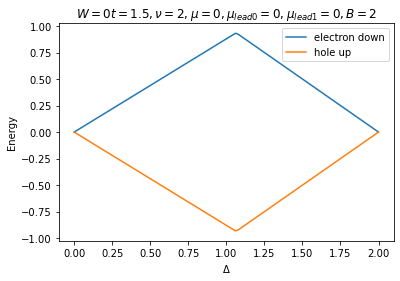

In [80]:
band_gap_array = delta_gap_scan()

plt.plot(np.linspace(0., 2, 101), band_gap_array[:,0], label='electron down')
plt.plot(np.linspace(0., 2, 101), band_gap_array[:,1], label='hole up')
plt.xlabel(r'$\Delta$')
plt.ylabel('Energy')
plt.title(r'$W=0 t=1.5, \nu=2, \mu=0, \mu_{lead0}=0, \mu_{lead1}=0, B=2$')
plt.legend()

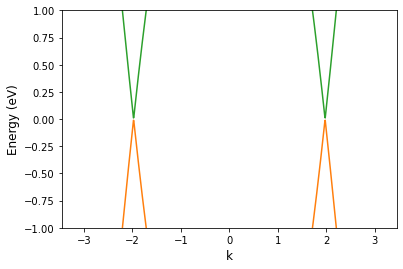

In [49]:
syst = make_system_mu(W=0, t=1.5, nu=2., mu=0., mu_lead0=0., mu_lead1=0., delta=0., B=2.)
bands=kwant.physics.Bands(syst.leads[1])
momenta=np.linspace(-np.pi,np.pi,1001)
energies=[bands(k) for k in momenta]

x=np.array(energies)
en=(x)
plt.ylim(-1,1)


plt.plot(momenta, en)
plt.ylabel('Energy (eV)', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.show()

In [5]:
def B_scan(W=0, t=1.5, nu=2., mu=0., mu_leads=0., delta=1., phi=0., E_range=1., rtol=1e-2, B_range=[0, 5]):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.arange(B_range[0], B_range[1], 0.1):
        print(i)
        syst = make_system_mu(W=W, B=i, t=t, nu=nu, mu=mu, mu_lead0=mu, mu_lead1=mu_leads, delta=delta, phi=phi)
        energies, wavefunctions = find_boundstates(syst, -E_range, E_range, rtol=rtol)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [74]:
syst = make_system_mu(W=0, B=2., t=1.5, nu=2., mu=0., mu_lead0=0., mu_lead1=0., delta=1e-1, phi=0.)
energies, wavefunctions = find_boundstates(syst, -1e-1, 1e-1, rtol=1e-3)
energies

array([-0.04713571,  0.04713571])

In [75]:
E_array = []
delta_array = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

for delta in delta_array:
    print(delta)
    syst = make_system_mu(W=0, B=2., t=1.5, nu=2., mu=0., mu_lead0=0., mu_lead1=0., delta=delta, phi=0.)
    energies, wavefunctions = find_boundstates(syst, -delta, delta, rtol=delta*1e-2)
    print(energies)
    E_array.append(energies[int(len(energies)/2)])

print(E_array)

1e-06
[-5.01166395e-07  5.01166395e-07]
1e-05
[-5.01163631e-06  5.01163631e-06]
0.0001
[-5.01135978e-05  5.01135978e-05]
0.001
[-0.00050086  0.00050086]
0.01
[-0.00498102  0.00498102]
0.1
[-0.04713571  0.04713571]
1
[-0.82484417 -0.29299719  0.29299719  0.82484417]
[5.011663949621468e-07, 5.011636309921862e-06, 5.011359776066392e-05, 0.0005008595179095787, 0.00498101556324894, 0.047135712340011286, 0.29299718867591473]


In [78]:
E_gap_array = []

for delta in delta_array:
    print(delta)
    syst = make_system_mu(W=0, B=2., t=1.5, nu=2., mu=0., mu_lead0=0., mu_lead1=0., delta=delta, phi=0.)
    bands=kwant.physics.Bands(syst.leads[1])
    momenta=np.linspace(-np.pi,np.pi,1000001)
    energies=[bands(k) for k in momenta]
    x=np.array(energies)
    en=(x)
    print(np.min(en[:,2]))
    E_gap_array.append(np.min(en[:,2]))
    
print(E_gap_array)

1e-06
1.804742778746284e-06
1e-05
8.924000143433438e-06
0.0001
8.785047515167299e-05
0.001
0.0008783646892496879
0.01
0.008783633305201103
0.1
0.08783670457825325
1
0.8787387393154318
[1.804742778746284e-06, 8.924000143433438e-06, 8.785047515167299e-05, 0.0008783646892496879, 0.008783633305201103, 0.08783670457825325, 0.8787387393154318]


In [79]:
print(np.array(E_array)/np.array(E_gap_array))

[0.27769409 0.56159079 0.57044197 0.57021818 0.56707918 0.53662888
 0.33342924]


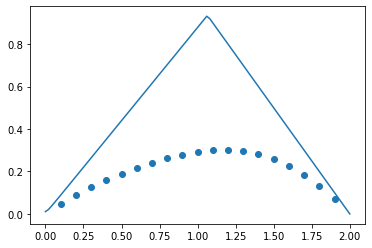

In [66]:
e_array_temp = []
for e in e_array[1:]:
    e_array_temp.append(e[int(len(e)/2)])
for e in e_array1[:-1]:
    e_array_temp.append(e[int(len(e)/2)])
plt.scatter(np.arange(0.1, 2., 0.1), e_array_temp)
plt.plot(np.linspace(0., 2, 101), band_gap_array[:,0])

0.0
[]
0.1
[]
0.2
[]
0.30000000000000004
[]
0.4
[-0.009861  0.009861]
0.5


KeyboardInterrupt: 

In [203]:
def B_gap_scan(t=1.5, nu=2., mu=0., mu_lead0=0., mu_lead1=0., delta=1., W=0, B_range=[0, 5], res=101):
    band_gap_array = []
    for i in np.linspace(B_range[0], B_range[1], res):
        syst = make_system_mu(t=t, nu=nu, mu=mu, mu_lead0=mu_lead0, mu_lead1=mu_lead1, delta=delta, W=W, B=i)
        bands=kwant.physics.Bands(syst.leads[1])
        momenta=np.linspace(-np.pi,np.pi,101)
        energies=[bands(k) for k in momenta]
        x=np.array(energies)
        en=(x)
        band_gap_array.append([np.min(en[:,2]), np.max(en[:,1])])
    return np.array(band_gap_array)